# Homework 3
Lu Yii Wong

24 Feb 2025

### Homework 
#### Please download DEM in Pennsylvania and run the HAND model

- Please download the DEM tiles for Pennsylvania
- Run the HAND model to estimate the inudation depth for each tile
- Export the results to geotiff
- Mosaic the exposed results into a complete `geotiff` for whole Pennsylvania.
- Upload your notebook and submit a report to present your map for PA.

Here is a hint about how to conduct the analysis for one tile. You can reference this for your homework. You need to generate the results for whole Pennsylvania. You will need to use loop to download DEM tiles for Pennsylvania, and conduct the mosaicing to generate the image for the whole state. 

Use the download-dem.ipynb to download the dem data for any location. 


In [3]:
# Import Libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
import pysheds
import numpy as np
import os
import requests
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
import fiona

## 1. Downloading DEM for Pennslyvania 

In [5]:
# Finding tiles that cover Pennslyvania, given the state's approximate lat-long coordinates (approximately 39-42°N, 74-81°W)

tile_names = [
    f"n{lat}w{str(lon).zfill(3)}"
    for lat in range(39, 44)  # 39 to 42
    for lon in range(74, 82)  # 74 to 81
]

print(tile_names)

['n39w074', 'n39w075', 'n39w076', 'n39w077', 'n39w078', 'n39w079', 'n39w080', 'n39w081', 'n40w074', 'n40w075', 'n40w076', 'n40w077', 'n40w078', 'n40w079', 'n40w080', 'n40w081', 'n41w074', 'n41w075', 'n41w076', 'n41w077', 'n41w078', 'n41w079', 'n41w080', 'n41w081', 'n42w074', 'n42w075', 'n42w076', 'n42w077', 'n42w078', 'n42w079', 'n42w080', 'n42w081', 'n43w074', 'n43w075', 'n43w076', 'n43w077', 'n43w078', 'n43w079', 'n43w080', 'n43w081']


In [6]:
# Check array length
print(len(tile_names))

40


In [7]:
# Create an output folder
output_folder = 'PA_DEM_tiles'

# Create the folder if it does not exist
os.makedirs(output_folder, exist_ok=True)

# Download all relevant DEM tiles
# Loop through each tile and download the corresponding DEM file
for tile_name in tile_names:
    tile_url = f"https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/current/{tile_name}/USGS_1_{tile_name}.tif"
    print(f"Downloading {tile_name}...")

    response = requests.get(tile_url)
    
    if response.status_code == 200:
        file_path = os.path.join(output_folder, f"{tile_name}.tif")
        with open(file_path, "wb") as file:
            file.write(response.content)
        print(f"DEM tile downloaded: {file_path}.tif")
    else:
        print(f"Failed to download {tile_name}. Check if the tile exists.")

print("All downloads completed!")

Failed to download n39w074. Check if the tile exists.
DEM tile downloaded: PA_DEM_tiles/n39w075.tif.tif
DEM tile downloaded: PA_DEM_tiles/n39w076.tif.tif
DEM tile downloaded: PA_DEM_tiles/n39w077.tif.tif
DEM tile downloaded: PA_DEM_tiles/n39w078.tif.tif
DEM tile downloaded: PA_DEM_tiles/n39w079.tif.tif
DEM tile downloaded: PA_DEM_tiles/n39w080.tif.tif
DEM tile downloaded: PA_DEM_tiles/n39w081.tif.tif
Failed to download n40w074. Check if the tile exists.
DEM tile downloaded: PA_DEM_tiles/n40w075.tif.tif
DEM tile downloaded: PA_DEM_tiles/n40w076.tif.tif
DEM tile downloaded: PA_DEM_tiles/n40w077.tif.tif
DEM tile downloaded: PA_DEM_tiles/n40w078.tif.tif
DEM tile downloaded: PA_DEM_tiles/n40w079.tif.tif
DEM tile downloaded: PA_DEM_tiles/n40w080.tif.tif
DEM tile downloaded: PA_DEM_tiles/n40w081.tif.tif
DEM tile downloaded: PA_DEM_tiles/n41w074.tif.tif
DEM tile downloaded: PA_DEM_tiles/n41w075.tif.tif
DEM tile downloaded: PA_DEM_tiles/n41w076.tif.tif
DEM tile downloaded: PA_DEM_tiles/n41w077.

## 2. Computing Flow Direction from DEM file

In [8]:
# Define input/output folders
input_folder = "PA_DEM_tiles"  
output_folder = "HAND_results"
inundation_output_folder = "Inundation_results"

os.makedirs(output_folder, exist_ok=True)
os.makedirs(inundation_output_folder, exist_ok=True)

# Define flood threshold (meters)
threshold = 5

# List all TIFF files in the input folder
dem_files = [f for f in os.listdir(input_folder) if f.endswith('.tif')]

# Process each DEM tile
for demfile in dem_files:
    dem_path = os.path.join(input_folder, demfile)
    
    print(f"Processing: {demfile}...")
    
    # Load DEM
    grid = Grid.from_raster(dem_path)
    dem = grid.read_raster(dem_path)

    # Fill pits
    pit_filled_dem = grid.fill_pits(dem)
    
    # Fill depressions
    flooded_dem = grid.fill_depressions(pit_filled_dem)

    # Resolve flats
    inflated_dem = grid.resolve_flats(flooded_dem)

    # Compute Flow Direction
    fdir = grid.flowdir(inflated_dem)

    # Compute Flow Accumulation
    acc = grid.accumulation(fdir)

    # Compute HAND (Height Above Nearest Drainage) 
    # Only considers areas where flow accumulation > 200 cells
    hand = grid.compute_hand(fdir, inflated_dem, acc > 200)

    # Compute Inundation Extent
    inundation_extent = np.where(hand < threshold, threshold - hand, np.nan)

    # Save HAND and Inundation Extent output as GeoTIFF
    hand_output_path = os.path.join(output_folder, f"HAND_{demfile}")
    inundation_output_path = os.path.join(inundation_output_folder, f"Inundation_{demfile}")
    
    with rasterio.open(dem_path) as src:
        profile = src.profile
        profile.update(dtype=rasterio.float32, compress="lzw")

        # Save HAND Files
        with rasterio.open(hand_output_path, "w", **profile) as dst:
            dst.write(hand, 1)

        # Save Inundation Extent
        with rasterio.open(inundation_output_path, "w", **profile) as dst:
            dst.write(inundation_extent, 1)
            
    print(f"Saved HAND model: {hand_output_path}")
    print(f"Saved Inundation Extent: {inundation_output_path}")

print("All HAND and Inundation Extent models processed!")

Processing: n41w080.tif...
Saved HAND model: HAND_results/HAND_n41w080.tif
Saved Inundation Extent: Inundation_results/Inundation_n41w080.tif
Processing: n41w081.tif...
Saved HAND model: HAND_results/HAND_n41w081.tif
Saved Inundation Extent: Inundation_results/Inundation_n41w081.tif
Processing: n40w079.tif...
Saved HAND model: HAND_results/HAND_n40w079.tif
Saved Inundation Extent: Inundation_results/Inundation_n40w079.tif
Processing: n40w078.tif...
Saved HAND model: HAND_results/HAND_n40w078.tif
Saved Inundation Extent: Inundation_results/Inundation_n40w078.tif
Processing: n41w079.tif...
Saved HAND model: HAND_results/HAND_n41w079.tif
Saved Inundation Extent: Inundation_results/Inundation_n41w079.tif
Processing: n41w078.tif...
Saved HAND model: HAND_results/HAND_n41w078.tif
Saved Inundation Extent: Inundation_results/Inundation_n41w078.tif
Processing: n40w080.tif...
Saved HAND model: HAND_results/HAND_n40w080.tif
Saved Inundation Extent: Inundation_results/Inundation_n40w080.tif
Proces

## 3. Mosaic Tiles for HAND and Inundation Extent Models

In [9]:
## UPDATE THIS SECTION FOR HAND MOSAIC 
# updating the input folder to where the HAND tif files are located
inputfolder= 'HAND_results'
outfile = 'HAND-mosaic.tif'

# start to mosaic the raster tiles
tiflist = []

for file in os.listdir(inputfolder):    
    if file.endswith('.tif'):
        tiffile = os.path.join(inputfolder, file)
        tiflist.append(tiffile)

# The try and except makes sure that the code is robust
# The command will continue to execute, even if one of the tiff file is corrupt
src_files_to_mosaic = []
for fp in tiflist:
    try:
        tile_src = rasterio.open(fp)
        tile_bounds = tile_src.bounds
        
        src_files_to_mosaic.append(tile_src)
    except:
        continue

# This should be 38
print('The number of mosaiced tiles is:', len(src_files_to_mosaic))

# the method can be set as min, max..
mosaic, out_trans = merge(src_files_to_mosaic) #, method='max'
print('You have mosaiced the results')


# Prepare the schema of the output mosaiced image
out_meta = tile_src.meta.copy()
out_meta.update({"driver": "GTiff",
                  "height": mosaic.shape[1],
                  "width": mosaic.shape[2],
                  "transform": out_trans, 
                  "compress": 'lzw',
                  'BIGTIFF': 'YES'
                  }
               )


with rasterio.open(outfile, "w", **out_meta) as dest:
     dest.write(mosaic)

print(f"Final mosaiced HAND model saved: {outfile}")

The number of mosaiced tiles is: 38
You have mosaiced the results
Final mosaiced HAND model saved: HAND-mosaic.tif


In [10]:
## UPDATE THIS SECTION FOR INUNDATION EXTENT 
# updating the input folder to where the HAND tif files are located
inputfolder= 'Inundation_results'
outfile = 'Inundation-mosaic.tif'

# start to mosaic the raster tiles
tiflist = []

for file in os.listdir(inputfolder):    
    if file.endswith('.tif'):
        tiffile = os.path.join(inputfolder, file)
        tiflist.append(tiffile)

# The try and except makes sure that the code is robust
# The command will continue to execute, even if one of the tiff file is corrupt
src_files_to_mosaic = []
for fp in tiflist:
    try:
        tile_src = rasterio.open(fp)
        tile_bounds = tile_src.bounds
        
        src_files_to_mosaic.append(tile_src)
    except:
        continue

# This should be 38
print('The number of mosaiced tiles is:', len(src_files_to_mosaic))

# the method can be set as min, max..
mosaic, out_trans = merge(src_files_to_mosaic) #, method='max'
print('You have mosaiced the results')


# Prepare the schema of the output mosaiced image
out_meta = tile_src.meta.copy()
out_meta.update({"driver": "GTiff",
                  "height": mosaic.shape[1],
                  "width": mosaic.shape[2],
                  "transform": out_trans, 
                  "compress": 'lzw',
                  'BIGTIFF': 'YES'
                  }
               )


with rasterio.open(outfile, "w", **out_meta) as dest:
     dest.write(mosaic)

print(f"Final mosaiced Inundation Extent model saved: {outfile}")

The number of mosaiced tiles is: 38
You have mosaiced the results
Final mosaiced Inundation Extent model saved: Inundation-mosaic.tif


## Mask Mosaic to PA shapefile

In [11]:
# Load in Pennsylvania Boundary Shapefile 

import geopandas as gpd

PA_boundary = "PA_Shapefile/PA_state.shp"
gdf = gpd.read_file(PA_boundary)

In [4]:
# Input raster layer 
HAND_input_raster = "HAND-mosaic.tif"
Inundation_raster = "Inundation-mosaic.tif"
# Load in PA boundary shapefile
PA_boundary = "PA_Shapefile/PA_state.shp"
# Output raster
out_raster = "mask-HAND.tif"
out_raster_inundation = "mask-Inundation.tif"

# Creating the mask for HAND model
with fiona.open(PA_boundary, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open(HAND_input_raster) as src:
    out_image, out_transform = mask(src, shapes, crop=True)
    out_meta = src.meta

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "compress": 'lzw',
                 "transform": out_transform})

with rasterio.open(out_raster, "w", **out_meta) as dest:
    dest.write(out_image)  


# Creating the mask for the Inundation Extent model
with fiona.open(PA_boundary, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open(Inundation_raster) as src:
    out_image, out_transform = mask(src, shapes, crop=True)
    out_meta = src.meta

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "compress": 'lzw',
                 "transform": out_transform})

with rasterio.open(out_raster_inundation, "w", **out_meta) as dest:
    dest.write(out_image)  


## 4. Plot Results

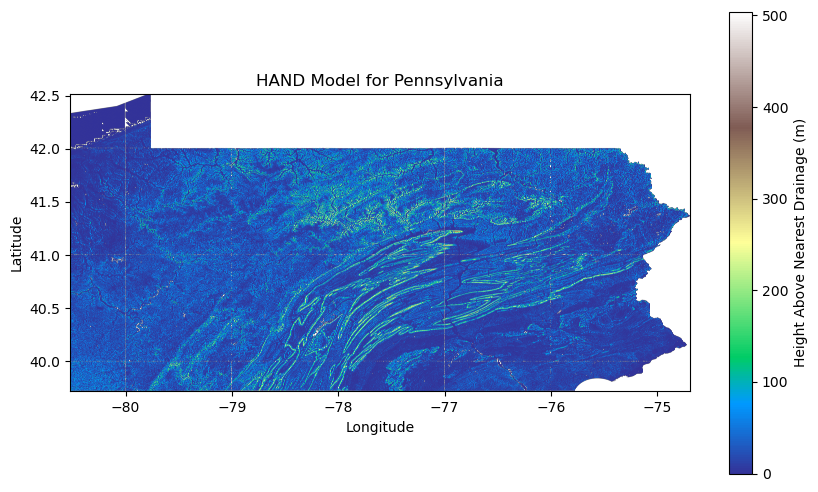

In [5]:
# Load the mosaicked HAND result
mosaic_hand_path = "mask-HAND.tif" 

with rasterio.open(mosaic_hand_path) as src:
    hand = src.read(1)  # Read the first band
    hand[hand == src.nodata] = np.nan  # Replace nodata values with NaN
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Plot HAND
plt.figure(figsize=(10, 6))
plt.imshow(hand, cmap="terrain", extent=extent)
plt.colorbar(label="Height Above Nearest Drainage (m)")
plt.title("HAND Model for Pennsylvania")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

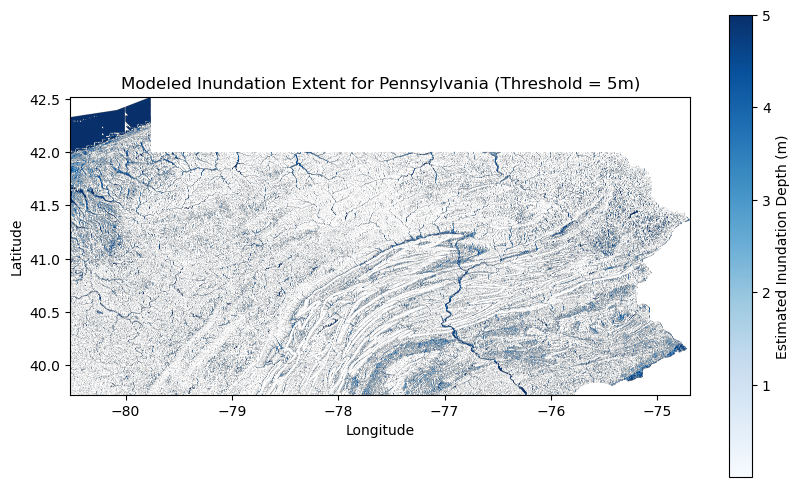

In [9]:
# Load inundation extent 
mosaic_inundation_path = "mask-Inundation.tif"

with rasterio.open(mosaic_inundation_path) as src:
    inundation = src.read(1)
    inundation[inundation == src.nodata] = np.nan

# Plot Inundation Extent
plt.figure(figsize=(10, 6))
plt.imshow(inundation, cmap="Blues", extent=extent)
plt.colorbar(label="Estimated Inundation Depth (m)")
plt.title("Modeled Inundation Extent for Pennsylvania (Threshold = 5m)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()